In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mogptk.gpr.kernel import MultiOutputKernel
from mogptk.gpr.kernel import ChangePointsKernel
from mogptk.gpr.singleoutput import SquaredExponentialKernel, LocallyPeriodicKernel, LinearKernel
from mogptk import Data, Model
from mogptk.gpr.likelihood import LaplaceLikelihood, GaussianLikelihood, \
    StudentTLikelihood
from mogptk.gpr import ConstantMean, LinearMean
from mogptk import Exact, Hensman, Titsias, LoadDataFrame, Model, TransformDetrend, TransformStandard

In [2]:
np.random.seed(1410)

Data

In [3]:
df = pd.read_csv('../examples/data/AirQualityUCI.csv', sep=';', skiprows=lambda i: i>=9358)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S')
df['timestamp'] = df[['Date', 'Time']].agg(
    func=lambda row: pd.Timestamp.combine(row['Date'], row['Time'].time()),
    axis=1
)
cols_meas = ['CO(GT)', 
           'PT08.S1(CO)',
           'NMHC(GT)', 
           'C6H6(GT)',
           'PT08.S2(NMHC)',
           'NOx(GT)', 
           'PT08.S3(NOx)', 
           'NO2(GT)', 
           'PT08.S4(NO2)', 
           'PT08.S5(O3)']
# Replace missing values with NaN
df = df.replace([-200, 200.0], np.nan, inplace=False)

# Downsampling
target_freq = pd.Timedelta(days=1)
df = df.resample(target_freq, on='timestamp', closed='left', label='right', origin='start').mean()
df.reset_index(drop=False, inplace=True)

# 
df['timestamp'] = (df['timestamp'] - df['timestamp'].iloc[0]) / target_freq
# df['timestamp']
df.drop(columns=['Date', 'Time'], inplace=True)

data = LoadDataFrame(
    df, x_col=['timestamp'],
    y_col=cols_meas
)

In [4]:
target_freq.__str__()

'1 days 00:00:00'

In [5]:
df.isna().sum()

timestamp          0
CO(GT)            36
PT08.S1(CO)        9
NMHC(GT)         347
C6H6(GT)           9
PT08.S2(NMHC)      9
NOx(GT)           33
PT08.S3(NOx)       9
NO2(GT)           33
PT08.S4(NO2)       9
PT08.S5(O3)        9
T                  9
RH                 9
AH                 9
Unnamed: 15      390
Unnamed: 16      390
dtype: int64

In [6]:
data['NOx(GT)']

     timestamp     NOx(GT)
0          0.0  118.130435
1          1.0  165.590909
2          2.0  189.782609
3          3.0  154.913043
4          4.0  201.434783
..         ...         ...
352      385.0  232.434783
353      386.0  150.791667
354      387.0  153.750000
355      388.0  138.291667
356      389.0  261.904762

[357 rows x 2 columns]

Obvious change at 2004-September

In [7]:
data_nox = data['NOx(GT)']
data_nox.remove(pct=0.25) # ratio of test data
# data_nox.transform(TransformDetrend(degree=1))
data_nox.transform(TransformStandard())

<Axes: title={'center': 'NOx(GT)'}, xlabel='timestamp', ylabel='NOx(GT)'>

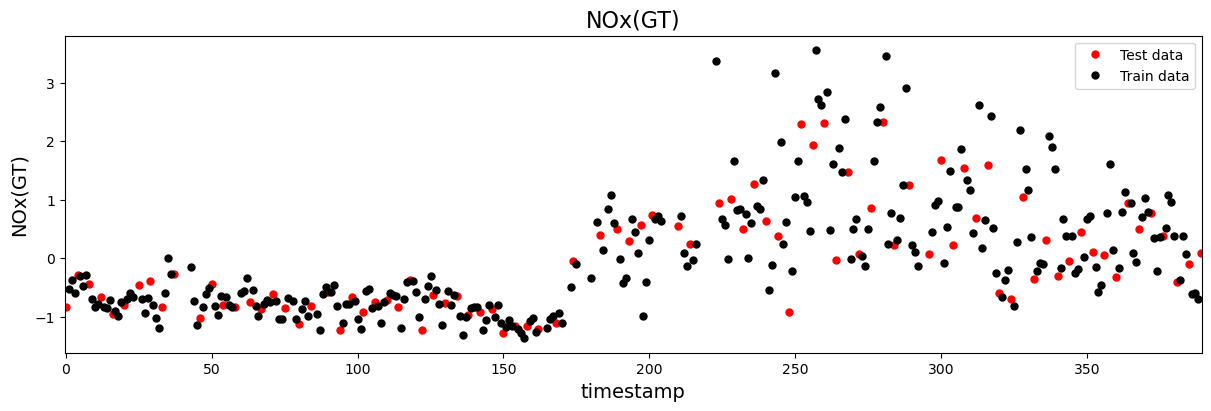

In [8]:
data_nox.plot(transformed=True)

We can see somekind of a "regime change" around a change point at $t \approx 170$. Both segments can be modelled by distinct `SquaredExponentialKernel` kernels, the first one with a larger lengthscale than the second one. This can be modelled by the so called "change point kernel" which can model an alternate of multiple base kernels.
In addition to the hyperparameters of the base kernels, it involves the change location and rate hyperparamters. Note that it is not restricted to kernels of the same family.

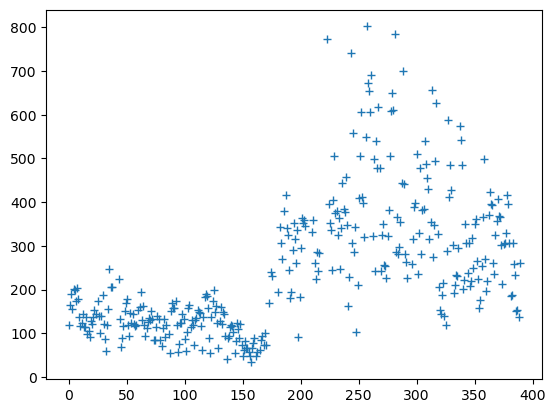

In [9]:
plt.plot(
    data_nox.get_data()[0],
    data_nox.get_data()[1],
    linestyle='None',
    marker='+'
)

Model + kernel specification

In [10]:
lik_scale = 1.0

The two segments show different noise levels, so we choose a robust likelihood so that the model is not to be influenced by outliers of the second segment.

In [ ]:
# Observation model
lik = StudentTLikelihood(dof=10, scale=lik_scale)

Each of the tow segments have a distinct kernel (of the same family). We add a `LocallyPeriodicKernel` kernel to the whole time series to consider the a priori weekly periodicity.

In [11]:
# initial guess for change location:
# np.where(data_nox.get_data()[1] >= 200) => index at 160 equiv to X~303900
cp_loc_guess = 160.0
k1 = LinearKernel() * SquaredExponentialKernel()
k2 = LinearKernel() * SquaredExponentialKernel()
kernel = ChangePointsKernel(
    [cp_loc_guess],
    1.5, # slope of the kenrel transition
    k1, k2
)
kernel = kernel + LocallyPeriodicKernel()

In [12]:
# Model
model = Model(
    dataset=data_nox,
    kernel=kernel,
    mean=ConstantMean(),
    inference=Hensman(inducing_points=20, init_inducing_points='density', likelihood=lik)
)

Initialize some of the hyperparameters.

In [13]:
model.gpr.likelihood.scale.assign(value=lik_scale, train=False)
# hyperparams init
# for k in [k1, k2]:
#     k.magnitude.assign(value=1.0, train=False)

model.gpr.kernel[0].locations.assign(value=cp_loc_guess, train=True)
model.gpr.kernel[0].steepness.assign(value=1.5, train=False)

# model.gpr.kernel[0][0][-1].period.assign(value=0.01, train=True)
# model.gpr.kernel[0][1][-1].period.assign(value=0.01, train=True)

model.gpr.kernel[1].period.assign(value=0.5, train=True)
model.gpr.kernel[1].magnitude.assign(value=0.5, train=True)

Training

Starting optimization using Adam
‣ Model: SparseHensman
  ‣ Kernel: [[[LinearKernel,SquaredExponentialKernel],[LinearKernel,SquaredExponentialKernel]],LocallyPeriodicKernel]
  ‣ Likelihood: StudentTLikelihood
  ‣ Mean: ConstantMean
‣ Channels: 1
‣ Parameters: 263
‣ Training points: 268
‣ Iterations: 10000
      0/10000   0:00:01  loss=     10280.3 (warmup)
    635/10000   0:00:10  loss=     923.366
   1225/10000   0:00:20  loss=     327.834
   1953/10000   0:00:30  loss=     268.425
   2789/10000   0:00:40  loss=     267.015
   3533/10000   0:00:50  loss=     266.655
   4304/10000   0:01:00  loss=     266.839
   5115/10000   0:01:10  loss=      264.76
   5873/10000   0:01:20  loss=     260.231
   6563/10000   0:01:30  loss=     259.645
   7232/10000   0:01:40  loss=      259.47
   7875/10000   0:01:50  loss=     259.571
   8504/10000   0:02:00  loss=     259.095
   9207/10000   0:02:10  loss=     259.054
   9884/10000   0:02:20  loss=     259.237
  10000/10000   0:02:21  loss=     258.

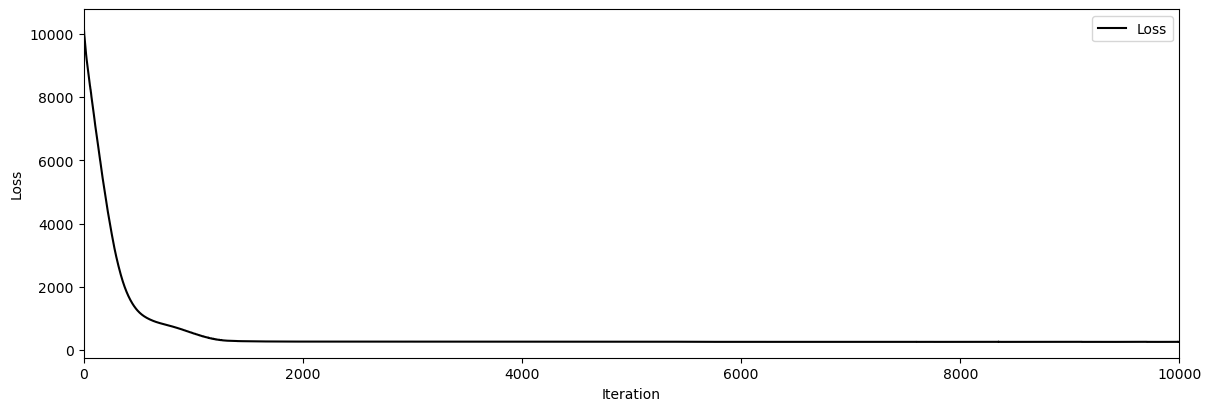

In [14]:
model.train(method='adam', lr=5e-2, betas=(0.7, 0.99), iters=10**4, plot=True, verbose=True)
model.print_parameters()

(-0.389, 389.389)

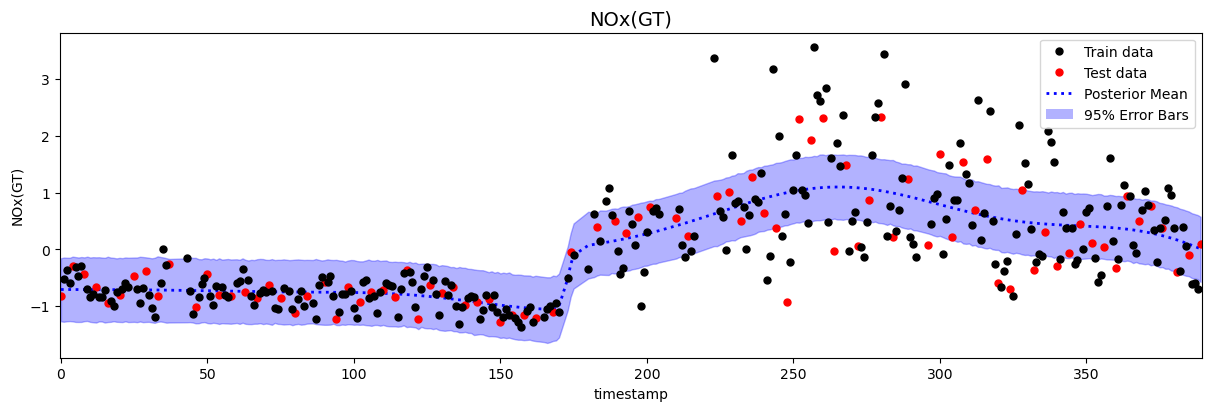

In [16]:
fig, ax = model.plot_prediction(transformed=True, sigma=1.0)
# ax[0, 0].vlines(, ymin=-3, ymax=3, linestyle='solid', color='brown')
ax[0, 0].get_xbound()

The posterior mean shows a higher temporal lengthscale ($\approx 58$) after the change location point (which has been learned as well) than before ($\approx 38$).